<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1> Discrete Short-Time Fourier Transform (STFT)</h1> 
</div>

<br/>

<p>
Following Section 2.1.4 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook a discrete version of the short-time Fourier transform (STFT).
</p> 

## Missing Time Localization

The Fourier transform yields frequency information that is averaged over the entire time domain. However, the information on **when** these frequencies occur is hidden in the transform. This phenomenon is illustrated by the following example.

<!-- <img src="../data/C2/FMP_C2_F06.png" width="500px" align="middle" alt="C0"> -->

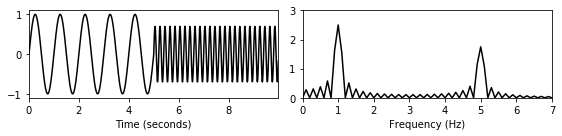

In [1]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
import librosa
from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
%matplotlib inline

Fs = 128
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / Fs
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X, c='k')
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

## Basic Idea

To recover the hidden time information, Dennis Gabor introduced in the year 1946 the **short-time Fourier transform** (STFT). Instead of considering the entire signal, the main idea of the STFT is to consider only a small section of the signal. To this end, one fixes a so-called **window function**, which is a function that is nonzero for only a short period of time (defining the considered section). The original signal is then multiplied with the window function to yield a **windowed signal**. To obtain frequency information at different time instances,  one shifts the window function across time and computes a Fourier transform for each of the resulting windowed signals. This idea is illustrated by the next example.

<!-- <img src="../data/C2/FMP_C2_F08.png" width="500px" align="middle" alt="C0"> -->

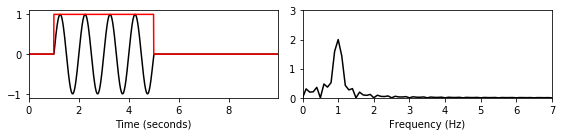

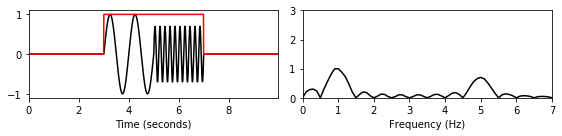

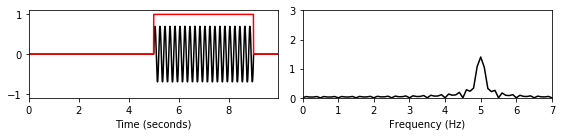

Interactive interface for experimenting with different window shifts:


interactive(children=(FloatSlider(value=1.7, continuous_update=False, description='Position', max=6.0), Output…

In [2]:
def windowed_ft(t, x, Fs, w_pos_sec, w_len):
    
    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w_padded = np.zeros(N)
    w_padded[w_pos:w_pos + w_len] = 1
    x = x * w_padded    
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w_padded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()
    
w_len = 4 * Fs
windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len)

print('Interactive interface for experimenting with different window shifts:')
interact(windowed_ft,
         w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=0.1, 
                continuous_update=False, value=1.7, description='Position'),
                t=fixed(t), x=fixed(x), Fs=fixed(Fs), w_len=fixed(w_len));

It is important to note that the STFT reflects not only the properties of the original signal but also those of the window function. First of all, the STFT depends on the **length of the window**, which determines the size of the section. Then, the STFT is influenced by the **shape of the window**. For example, the sharp edges of the rectangular window typically introduce "ripple" artifacts. We discuss such issues in more detail later.

## Formal Definition of the Discrete STFT

We now consider the discrete case of the STFT and specify the most important mathematical formulas as needed in practical applications. Let $x:[0:L-1]:=\{0,1,\ldots,L-1\}\to{\mathbb R}$ be a real-valued discrete-time (DT) signal of length $L$ obtained by equidistant sampling with respect to a fixed sampling rate $F_\mathrm{s}$ given in Hertz. Furthermore, let $w:[0:N-1]\to\mathbb{R}$ be a sampled  window function of length $N\in\mathbb{N}$. For example, in the case of a rectangular window one has $w(n)=1$ for $n\in[0:N-1]$. The length parameter $N$ determines the duration of the considered sections, which amounts to $N/F_\mathrm{s}$ seconds. One also introduces an additional parameter $H\in\mathbb{N}$, which is referred to as the **hop size**.  The hop size parameter is specified in samples and determines the step size in which the window is to be shifted across the signal. With regard to these parameters, the **discrete STFT** $\mathcal{X}$ of the signal $x$ is given by  

\begin{eqnarray}
   \mathcal{X}(m,k):= \sum_{n=0}^{N-1} x(n+mH)w(n)\mathrm{exp}(-2\pi ikn/N)
\end{eqnarray} 

with $m\in[0:M]$ and $k\in[0:K]$. The number $M:=\lfloor \frac{L-N}{H} \rfloor$ is the maximal frame index such that the window's time range is fully contained in the signal's time range. (We will see later some variants using padding strategies.) Furthermore, $K=N/2$ (assuming that $N$ is even) is the frequency index corresponding to the Nyquist frequency. The complex number $ \mathcal{X}(m,k)$ denotes the $k^{\mathrm{th}}$ Fourier coefficient for the $m^{\mathrm{th}}$ time frame.  Note that for each fixed time frame $m$, one obtains a **spectral vector** of size $K+1$ given by the coefficients $\mathcal{X}(m,k)$ for $k\in[0:K]$. The computation of each such spectral vector amounts to a DFT of size $N$, which can be done efficiently using the FFT (see <td style="border:none; text-align:left"><a href="../C2/C2_DFT-FFT.html">the FMP notebook on the FFT)</a>.



## Spectrogram

The **spectrogram** is a two-dimensional representation of the squared magnitude of the STFT:

\begin{eqnarray}
    \mathcal{Y}(m,k):= | \mathcal{X}(m,k)|^2.
\end{eqnarray} 

It can be visualized by means of a two-dimensional image, where the horizontal axis represents time and the vertical axis represents frequency. In this image, the spectrogram value $ \mathcal{Y}(m,k)$ is represented by the intensity or color in the image at the coordinate $(m,k)$. Note that in the discrete case, the time axis is indexed by the frame indices $m$ and the frequency axis is indexed by the frequency indices $k$.

<!-- <img src="../data/C2/FMP_C2_F09b.png" width="300px" align="middle" alt="C0"> -->

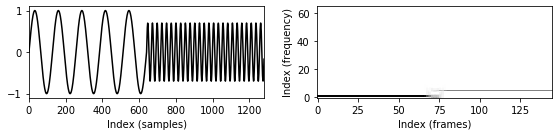

In [3]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-Basic.ipynb

    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function
        H (int): Hopsize (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)

    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X

H = 8
N = 128
w = np.ones(N)
X = stft_basic(x, w, H, only_positive_frequencies=True)
Y = np.abs(X) ** 2

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(t)), x, c='k')
plt.xlim([0, len(t)])
plt.xlabel('Index (samples)')
plt.subplot(1, 2, 2)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
plt.xlabel('Index (frames)')
plt.ylabel('Index (frequency)')
plt.tight_layout()

## Interpretation of Time and Frequency Indices

As for the temporal dimension, each Fourier coefficient $\mathcal{X}(m,k)$ is associated with the physical time position 

\begin{equation}
         T_\mathrm{coef}(m) := \frac{m\cdot H}{F_\mathrm{s}}
\end{equation}

given in seconds. For example, for the smallest possible hop size $H=1$, one obtains $T_\mathrm{coef}(m)=m/F_\mathrm{s}=m\cdot T~\sec$. In this case, one obtains a spectral vector for each sample of the DT-signal $x$, which results in a huge increase in data volume. Furthermore, considering sections that are only shifted by one sample generally yields very similar spectral vectors. To reduce this type of redundancy, one typically relates the hop size to the length $N$ of the window. For example, one often chooses $H=N/2$, which constitutes a good trade-off between a reasonable temporal resolution and the data volume comprising all generated spectral coefficients. As for the frequency dimension, the index $k$ of $\mathcal{X}(m,k)$ corresponds to the physical frequency

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

given in Hertz. 

<!-- <img src="../data/C2/FMP_C2_F09d.png" width="300px" align="middle" alt="C0"> -->

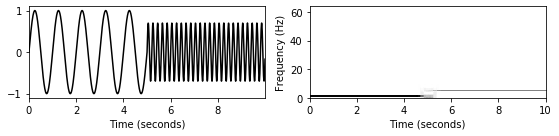

In [4]:
T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N

plt.figure(figsize=(8, 2))

plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', 
           extent=[left, right, lower, upper])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()

## Example

As an illustrative example, we consider a recording of a C-major scale played on a piano. In the following figure, the spectrogram representation of the recording is shown, where the time and frequency axes are labeled in a physically meaningful way. Furthermore, the spectrogram is also shown using a logarithmic dB scale (to enhance small sound components that may still be perceptually relevant).

The spectrogram reveals the frequency information of the played notes over time. For each note, one can observe horizontal lines that are stacked on top of each other. These equally spaced lines correspond to the partials, the integer multiples of the fundamental frequency of a note. Obviously, the higher partials contain less and less of the signal's energy. Furthermore, the decay of each note over time is reflected by the fading out of the horizontal lines.

<img src="../data/C2/FMP_C2_F10a.png" width="300px" align="left" alt="C0">

<br clear="all" />

<audio src="../data/C2/FMP_C2_F10.wav" type="audio/mpeg" controls="controls"></audio>

<!-- <img src="../data/C2/FMP_C2_F10.png" width="500px" align="middle" alt="C0"> -->

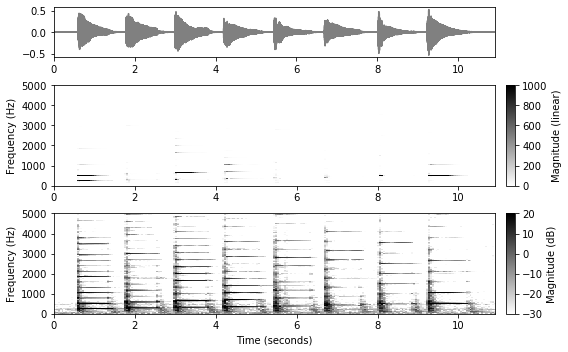

In [5]:
fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F10.wav')
x, Fs = librosa.load(fn_wav)

H = 1024
N = 2048
w = np.hanning(N)
X = stft_basic(x, w, H)
Y = np.abs(X) ** 2
eps = np.finfo(float).eps
Y_db = 10 * np.log10(Y + eps)

T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N


fig = plt.figure(figsize=(8, 5))

gs = matplotlib.gridspec.GridSpec(3, 2, height_ratios=[1, 2, 2], width_ratios=[100, 2])
ax1, ax2, ax3, ax4, ax5, ax6 = [plt.subplot(gs[i]) for i in range(6)]

t = np.arange(len(x)) / Fs
ax1.plot(t, x, c='gray')
ax1.set_xlim([min(t), max(t)])

ax2.set_visible(False)

left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)

im1 = ax3.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', 
                 extent=[left, right, lower, upper])
im1.set_clim([0, 1000])
ax3.set_ylim([0, 5000])
ax3.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im1, cax=ax4)
ax4.set_ylabel('Magnitude (linear)', rotation=90)

im2 = ax5.imshow(Y_db, origin='lower', aspect='auto', cmap='gray_r', 
                 extent=[left, right, lower, upper])
im2.set_clim([-30, 20])
ax5.set_ylim([0, 5000])
ax5.set_xlabel('Time (seconds)')
ax5.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im2, cax=ax6)
ax6.set_ylabel('Magnitude (dB)', rotation=90)

plt.tight_layout()

## Further Notes

We also provide an implementation of the STFT in our library `libfmp`. This implementation also includes padding options and realizes the centric view as used in the FMP notebooks. For details and similar options, we refer to the [FMP notebook on conventions and implementations](../C2/C2_STFT-Conventions.html) and the documentation of `librosa`. In the following code cell, we call the `libfmp` function.

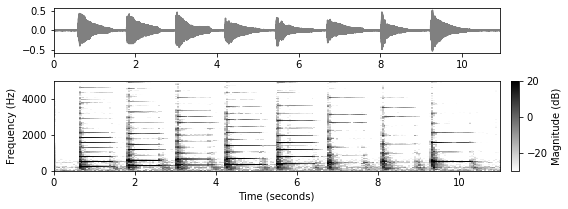

In [6]:
import sys
sys.path.append('..')
import libfmp.c2

fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F10.wav')
x, Fs = librosa.load(fn_wav)

H = 1024
N = 2048
w = np.hanning(N)
X = libfmp.c2.stft(x, w, H)
Y = np.abs(X) ** 2
eps = np.finfo(float).eps
Y_db = 10 * np.log10(Y + eps)

T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N


fig = plt.figure(figsize=(8, 3))

gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[100, 2])

ax1, ax2, ax3, ax4 = [plt.subplot(gs[i]) for i in range(4)]

t = np.arange(len(x)) / Fs
ax1.plot(t, x, c='gray')
ax1.set_xlim([min(t), max(t)])

ax2.set_visible(False)

left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)

im = ax3.imshow(Y_db, origin='lower', aspect='auto', cmap='gray_r', 
                 extent=[left, right, lower, upper])
im.set_clim([-30, 20])
ax3.set_ylim([0, 5000])
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im, cax=ax4)
ax4.set_ylabel('Magnitude (dB)', rotation=90)

plt.tight_layout()

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>